# Task 3: Rule Mining & Validation
> "Happiness can be found even in the darkest of times, if only one remembers to turn on the light" ~Albus

## Objective
Discover logical rules in the family knowledge graph and validate them using:
- **Confidence**: How often the rule holds (true conclusions / when premise is satisfied)
- **Support**: How many instances of this rule exist
- **Examples**: Concrete instances from the dataset

## Rule 1:
**`motherOf(X,Y) ^ motherOf(Y,Z) -> grandmotherOf(X,Z)`**

In plain English: If X is the mother of Y, and Y is also the mother of Z, then X is the grandmother of Z.


**Note**: This restricted rule only checks the mother->mother path, so it will have lower coverage than a rule that includes both parent paths.

In [44]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")

In [45]:
# Load data
file_path = "train.txt"
triples = []
with open(file_path) as f:
    for line in f:
        h, r, t = line.strip().split()
        triples.append((h, r, t))

G = nx.MultiDiGraph()
for h, r, t in triples:
    G.add_edge(h, t, relation=r)

print(f"Total triples: {len(triples)}")
print(f"Total people: {G.number_of_nodes()}")
print(f"Total directed edges: {G.number_of_edges()}")

Total triples: 13821
Total people: 1316
Total directed edges: 13821


In [46]:
mother_pairs = {}
for h, r, t in triples:
    if r == "motherOf":
        if h not in mother_pairs:
            mother_pairs[h] = []
        mother_pairs[h].append(t)

print(f"Found {len(mother_pairs)} mothers in dataset")
print(f"Total mother-child pairs: {sum(len(v) for v in mother_pairs.values())}")

father_pairs = {} #used in next rule
for h, r, t in triples:
    if r == "fatherOf":
        if h not in father_pairs:
            father_pairs[h] = []
        father_pairs[h].append(t)

print(f"Found {len(father_pairs)} fathers in dataset")
print(f"Total father-child pairs: {sum(len(v) for v in father_pairs.values())}")

actual_grandmother_pairs = set()
for h, r, t in triples:
    if r == "grandmotherOf":
        actual_grandmother_pairs.add((h, t))

print(f"Found {len(actual_grandmother_pairs)} actual grandmotherOf relationships")


Found 445 mothers in dataset
Total mother-child pairs: 733
Found 445 fathers in dataset
Total father-child pairs: 733
Found 813 actual grandmotherOf relationships


In [47]:
rule_instances = []
rule_valid = []

for X, children_of_X in mother_pairs.items():
    for Y in children_of_X:
        
        if Y in mother_pairs:
            for Z in mother_pairs[Y]:
                rule_instances.append((X, Y, Z))
                if (X, Z) in actual_grandmother_pairs:
                    rule_valid.append((X, Y, Z))

reverse_check = 0
reverse_valid = 0
for X, Z in actual_grandmother_pairs:
    found = False
    for valid_inst in rule_valid:
        if valid_inst[0] == X and valid_inst[2] == Z:
            found = True
            break
    reverse_check += 1
    if found:
        reverse_valid += 1

reverse_missing = reverse_check - reverse_valid

# Confidence = How many predictions are correct (precision)
confidence = len(rule_valid) / len(rule_instances) if rule_instances else 0
# Coverage = How many actual relationships we found (recall)
coverage = reverse_valid / reverse_check if reverse_check else 0
support = len(rule_valid)

gm_total = reverse_check
gm_predicted = reverse_valid
gm_missing = reverse_missing
gm_confidence = confidence
gm_coverage = coverage
gm_support = support

print("RULE 1 : motherOf(X,Y) ^ motherOf(Y,Z) -> grandmotherOf(X,Z) ")
print(f"\nTotal grandmother pairs in dataset: {reverse_check}")
print(f"Predicted by rule (coverage): {reverse_valid}")
print(f"Not predicted by rule: {reverse_missing}")
print(f"\nRule predictions made: {len(rule_instances)}")
print(f"Correct predictions: {len(rule_valid)}")

print(f"\nConfidence (Precision): {confidence:.4f} ({confidence*100:.2f}%)")
print(f"Coverage (Recall): {coverage:.4f} ({coverage*100:.2f}%)")
print(f"Support: {support}")

RULE 1 : motherOf(X,Y) ^ motherOf(Y,Z) -> grandmotherOf(X,Z) 

Total grandmother pairs in dataset: 813
Predicted by rule (coverage): 309
Not predicted by rule: 504

Rule predictions made: 309
Correct predictions: 309

Confidence (Precision): 1.0000 (100.00%)
Coverage (Recall): 0.3801 (38.01%)
Support: 309


## Concrete Examples from Dataset

In [48]:
print("\nConcrete Examples:")

for i, (X, Y, Z) in enumerate(rule_valid[:-1], 1):
    print(f"  {i}. {X} (mother)-> {Y} (mother)-> {Z}")
    print(f"     Rule predicts: grandmotherOf({X}, {Z})\n ")


Concrete Examples:
  1. emma7 (mother)-> paula12 (mother)-> johanna22
     Rule predicts: grandmotherOf(emma7, johanna22)
 
  2. karin41 (mother)-> beate36 (mother)-> marcel27
     Rule predicts: grandmotherOf(karin41, marcel27)
 
  3. luisa47 (mother)-> maria38 (mother)-> hannah39
     Rule predicts: grandmotherOf(luisa47, hannah39)
 
  4. alina32 (mother)-> sofia28 (mother)-> raphael29
     Rule predicts: grandmotherOf(alina32, raphael29)
 
  5. victoria53 (mother)-> elena55 (mother)-> tobias57
     Rule predicts: grandmotherOf(victoria53, tobias57)
 
  6. victoria53 (mother)-> elena55 (mother)-> magdalena59
     Rule predicts: grandmotherOf(victoria53, magdalena59)
 
  7. larissa76 (mother)-> helena67 (mother)-> sebastian56
     Rule predicts: grandmotherOf(larissa76, sebastian56)
 
  8. amelie62 (mother)-> victoria53 (mother)-> elena55
     Rule predicts: grandmotherOf(amelie62, elena55)
 
  9. lea80 (mother)-> amelie81 (mother)-> jonas101
     Rule predicts: grandmotherOf(lea80, 

## Summary Statistics Table

In [49]:
summary_data = {
    "Metric": [
        "Total in Dataset",
        "Predicted by Rule",
        "Missing from Rule",
        "Confidence (Precision)",
        "Coverage (Recall)",
        "Support"
    ],
    "Value": [
        gm_total,
        gm_predicted,
        gm_missing,
        f"{gm_confidence:.4f} ({gm_confidence*100:.2f}%)",
        f"{gm_coverage:.4f} ({gm_coverage*100:.2f}%)",
        gm_support
    ]
}

df_summary = pd.DataFrame(summary_data)

display(df_summary.style.hide(axis="index"))


Metric,Value
Total in Dataset,813
Predicted by Rule,309
Missing from Rule,504
Confidence (Precision),1.0000 (100.00%)
Coverage (Recall),0.3801 (38.01%)
Support,309


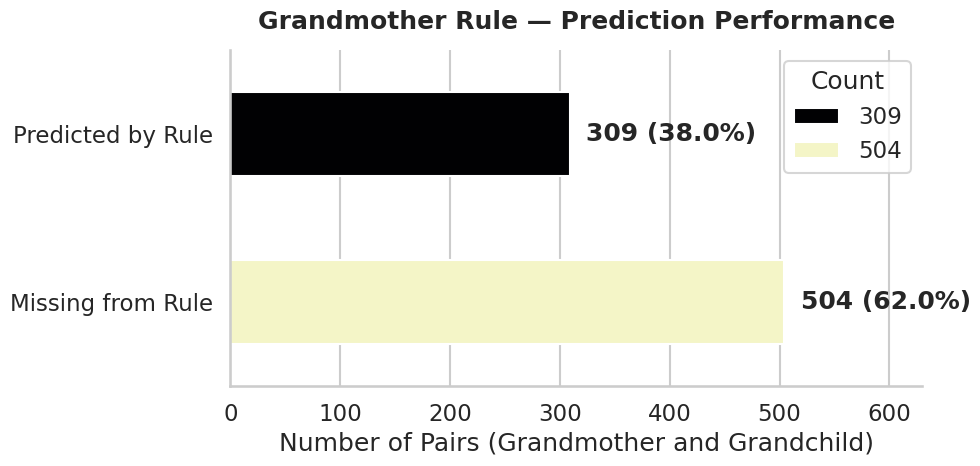



This rule only checks mother→mother paths (e.g., X is mother of Y,
Y is mother of Z). The remaining 62% of grandmother relationships
in the dataset involve father paths, such as:
  mother -> father paths eg:(grandmother->father->child)

The rule is precise (100% of predictions are correct) but incomplete (misses 504 grandmother pairs).



In [ ]:
df = pd.DataFrame({
    "Category": [
        "Predicted by Rule",
        "Missing from Rule"
    ],
    "Count": [
        gm_predicted,
        gm_missing
    ]
})

total = df["Count"].sum()
df["Percent"] = df["Count"] / total * 100


plt.figure(figsize=(10,5))

ax = sns.barplot(
    data=df,
    y="Category",
    x="Count",
    hue="Count",
    palette="magma",
    width=0.5   
)

xmax = df["Count"].max()

for i, row in df.iterrows():
    ax.text(
        row["Count"] + xmax*0.03,
        i,
        f'{row["Count"]} ({row["Percent"]:.1f}%)',
        va="center",
        fontweight="bold"
    )

plt.title("Grandmother Rule — Prediction Performance", pad=15, weight="bold")
plt.xlabel("Number of Pairs (Grandmother and Grandchild)")
plt.ylabel("")

plt.xlim(0, xmax * 1.25) 

sns.despine()
plt.tight_layout()
plt.show()

print("\n" )
print("This rule only checks mother->mother paths (e.g., X is mother of Y,")
print("Y is mother of Z). The remaining 62% of grandmother relationships")
print("in the dataset involve father paths, such as:")
print("  mother -> father paths eg:(grandmother->father->child)")
print("")
print("The rule is precise (100% of predictions are correct) but incomplete (misses 504 grandmother pairs).")
print("")




# Rule 2: Sibling Inference from Shared Father

**Rule**: `fatherOf(X,Y) ^ fatherOf(X,Z) ^ (Y != Z) ->(sisterOf(Y,Z) v brotherOf(Y,Z))`

In plain English: If X is the father of both Y and Z (and Y and Z are different people), then Y and Z are siblings.



In [51]:

sister_pairs = {(h, t) for h, r, t in triples if r == "sisterOf"}
brother_pairs = {(h, t) for h, r, t in triples if r == "brotherOf"}

def sibling_exists(Y, Z):
    return (
        (Y, Z) in sister_pairs or (Z, Y) in sister_pairs or
        (Y, Z) in brother_pairs or (Z, Y) in brother_pairs
    )



In [52]:
sibling_rule_instances = []
sibling_valid = []
seen_pairs = set()

for X, children in father_pairs.items():
    for i, Y in enumerate(children):
        for Z in children[i+1:]:
            key = tuple(sorted((Y, Z)))
            if key in seen_pairs:
                continue
            seen_pairs.add(key)

            sibling_rule_instances.append((X, Y, Z))

            if sibling_exists(Y, Z):
                sibling_valid.append((X, Y, Z))

In [53]:
actual_sibling_pairs = {
    tuple(sorted((h, t)))
    for h, r, t in triples
    if r in ("sisterOf", "brotherOf")
}

reverse_check = 0
reverse_valid = 0

for Y, Z in actual_sibling_pairs:
    found = False
    for inst in sibling_valid:
        if tuple(sorted((inst[1], inst[2]))) == (Y, Z):
            found = True
            break

    reverse_check += 1
    if found:
        reverse_valid += 1

reverse_missing = reverse_check - reverse_valid


In [ ]:
confidence = len(sibling_valid) / len(sibling_rule_instances) if sibling_rule_instances else 0
coverage = reverse_valid / reverse_check if reverse_check else 0

print("RULE 2: fatherOf(X,Y) ^ fatherOf(X,Z) ^ (Y != Z) -> (sisterOf(Y,Z) v brotherOf(Y,Z))")
print(f"\nTotal sibling pairs in dataset: {reverse_check}")
print(f"Predicted by rule (coverage): {reverse_valid}")
print(f"Not predicted by rule: {reverse_missing}")
print(f"\nRule predictions made: {len(sibling_rule_instances)}")
print(f"Correct predictions: {len(sibling_valid)}")



print(f"\nConfidence (Precision): {confidence:.4f} ({confidence*100:.2f}%)")
print(f"Support: {len(sibling_valid)}")
print(f"Coverage (Recall): {coverage:.4f} ({coverage*100:.2f}%)")

RULE 2: fatherOf(X,Y) ^ fatherOf(X,Z) ^ (Y != Z) -> (sisterOf(Y,Z) v brotherOf(Y,Z))

Total sibling pairs in dataset: 603
Predicted by rule (coverage): 440
Not predicted by rule: 163

Rule predictions made: 440
Correct predictions: 440

Confidence (Precision): 1.0000 (100.00%)
Support: 440
Coverage (Recall): 0.7297 (72.97%)


In [55]:
print("\nConcrete Examples:")
for i, (X, Y, Z) in enumerate(sibling_valid[:-1], 1):
    print(f"  {i}. {X} (father)-> {Y}, {X} (father)-> {Z}")
    print(f"     Rule predicts: siblingOf({Y}, {Z})\n")


Concrete Examples:
  1. dominik2 (father)-> selina10, dominik2 (father)-> isabella11
     Rule predicts: siblingOf(selina10, isabella11)

  2. dominik2 (father)-> selina10, dominik2 (father)-> oskar24
     Rule predicts: siblingOf(selina10, oskar24)

  3. dominik2 (father)-> selina10, dominik2 (father)-> adam9
     Rule predicts: siblingOf(selina10, adam9)

  4. dominik2 (father)-> isabella11, dominik2 (father)-> oskar24
     Rule predicts: siblingOf(isabella11, oskar24)

  5. dominik2 (father)-> isabella11, dominik2 (father)-> adam9
     Rule predicts: siblingOf(isabella11, adam9)

  6. dominik2 (father)-> oskar24, dominik2 (father)-> adam9
     Rule predicts: siblingOf(oskar24, adam9)

  7. oliver3 (father)-> lisa5, oliver3 (father)-> elias6
     Rule predicts: siblingOf(lisa5, elias6)

  8. moritz8 (father)-> paula12, moritz8 (father)-> natalie13
     Rule predicts: siblingOf(paula12, natalie13)

  9. moritz8 (father)-> paula12, moritz8 (father)-> luis14
     Rule predicts: sibling

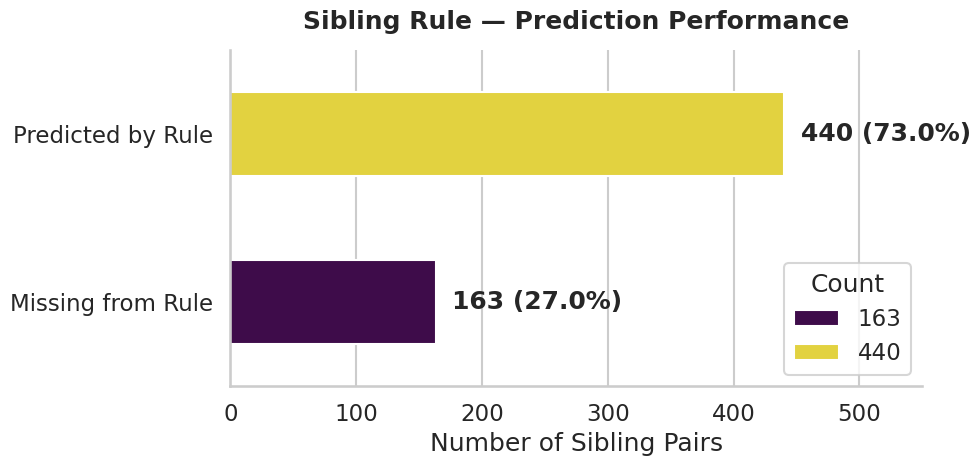

This rule only checks siblings who share the same FATHER
By only looking at shared fathers, we miss sibling pairs that
are connected through mother


In [56]:

df = pd.DataFrame({
    "Category": [
        "Predicted by Rule",
        "Missing from Rule"
    ],
    "Count": [
        len(sibling_valid),
        reverse_missing
    ]
})

total = df["Count"].sum()
df["Percent"] = df["Count"] / total * 100



plt.figure(figsize=(10,5))

ax = sns.barplot(
    data=df,
    y="Category",
    x="Count",
    hue="Count",
    palette="viridis",
    width=0.5
)

xmax = df["Count"].max()

for i, row in df.iterrows():
    ax.text(
        row["Count"] + xmax*0.03,
        i,
        f'{row["Count"]} ({row["Percent"]:.1f}%)',
        va="center",
        fontweight="bold"
    )

plt.title("Sibling Rule — Prediction Performance", pad=15, weight="bold")
plt.xlabel("Number of Sibling Pairs")
plt.ylabel("")

plt.xlim(0, xmax * 1.25)

sns.despine()
plt.tight_layout()
plt.show()

print("This rule only checks siblings who share the same FATHER")

print("By only looking at shared fathers, we miss sibling pairs that")
print("are connected through mother")


# Rule 3: Aunt Inference from Sister and Son



**Rule**: `sisterOf(X,Y) ^ sonOf(Z,Y) -> auntOf(X,Z)`

In plain English: If X is the sister of Y, and Z is the son of Y, then X is the aunt of Z.

In [57]:
sister_pairs = {(h, t) for h, r, t in triples if r == "sisterOf"}
son_pairs = {(h, t) for h, r, t in triples if r == "sonOf"}

actual_aunt_pairs = {(h, t) for h, r, t in triples if r == "auntOf"}



In [58]:
aunt_rule_instances = []
aunt_valid = []

for X, Y in sister_pairs:          
    for Z, parent in son_pairs:  
        if parent == Y:

            aunt_rule_instances.append((X, Y, Z))

            if (X, Z) in actual_aunt_pairs:
                aunt_valid.append((X, Y, Z))

print("Aunt rule instances generated")


Aunt rule instances generated


In [59]:
reverse_check = 0
reverse_valid = 0

for X, Z in actual_aunt_pairs:
    found = False
    for inst in aunt_valid:
        if inst[0] == X and inst[2] == Z:
            found = True
            break

    reverse_check += 1
    if found:
        reverse_valid += 1

reverse_missing = reverse_check - reverse_valid


In [60]:
# Confidence = How many predictions are correct (precision)
confidence = len(aunt_valid) / len(aunt_rule_instances) if aunt_rule_instances else 0
# Coverage = How many actual relationships we found (recall)
coverage = reverse_valid / reverse_check if reverse_check else 0

print("RULE 3: sisterOf(X,Y) ^ sonOf(Z,Y) -> auntOf(X,Z) ")
print(f"\nTotal aunt pairs in dataset: {reverse_check}")
print(f"Predicted by rule (coverage): {reverse_valid}")
print(f"Not predicted by rule: {reverse_missing}")
print(f"\nRule predictions made: {len(aunt_rule_instances)}")
print(f"Correct predictions: {len(aunt_valid)}")



print(f"\nConfidence (Precision): {confidence:.4f} ({confidence*100:.2f}%)")
print(f"Support: {len(aunt_valid)}")
print(f"Coverage (Recall): {coverage:.4f} ({coverage*100:.2f}%)")

RULE 3: sisterOf(X,Y) ^ sonOf(Z,Y) -> auntOf(X,Z) 

Total aunt pairs in dataset: 556
Predicted by rule (coverage): 226
Not predicted by rule: 330

Rule predictions made: 226
Correct predictions: 226

Confidence (Precision): 1.0000 (100.00%)
Support: 226
Coverage (Recall): 0.4065 (40.65%)


In [61]:
print("\nConcrete Examples:")
for i, (X, Y, Z) in enumerate(aunt_valid[:-1], 1):
    print(f"  {i}. {X} (sister)-> {Y}, {Z} (son)-> {Y}")
    print(f"     Rule predicts: auntOf({X}, {Z})\n")


Concrete Examples:
  1. helena1260 (sister)-> dominik1245, fabian1247 (son)-> dominik1245
     Rule predicts: auntOf(helena1260, fabian1247)

  2. helena1260 (sister)-> dominik1245, elias1253 (son)-> dominik1245
     Rule predicts: auntOf(helena1260, elias1253)

  3. helena1260 (sister)-> dominik1245, nico1246 (son)-> dominik1245
     Rule predicts: auntOf(helena1260, nico1246)

  4. helena1260 (sister)-> dominik1245, gabriel1248 (son)-> dominik1245
     Rule predicts: auntOf(helena1260, gabriel1248)

  5. mia595 (sister)-> marcel580, paul583 (son)-> marcel580
     Rule predicts: auntOf(mia595, paul583)

  6. mia595 (sister)-> marcel580, theodor578 (son)-> marcel580
     Rule predicts: auntOf(mia595, theodor578)

  7. sarah776 (sister)-> anastasia769, michael775 (son)-> anastasia769
     Rule predicts: auntOf(sarah776, michael775)

  8. katharina617 (sister)-> lea618, adam627 (son)-> lea618
     Rule predicts: auntOf(katharina617, adam627)

  9. nora825 (sister)-> theodor816, maximili

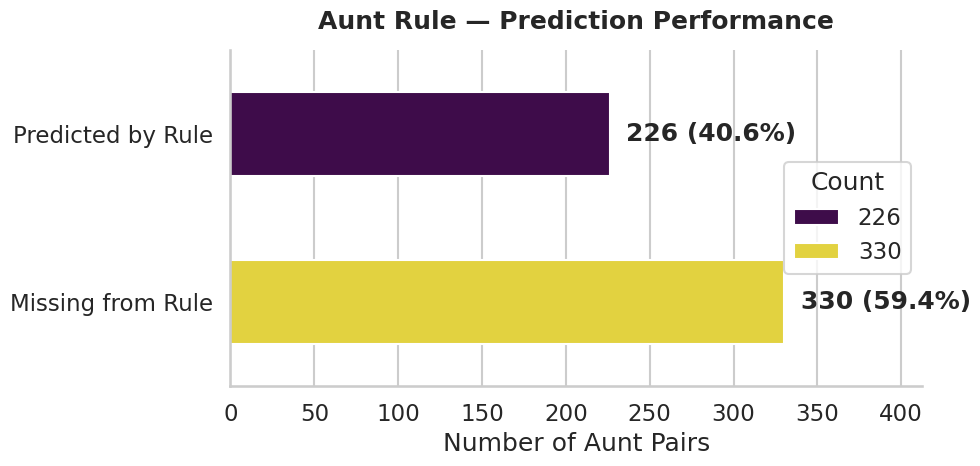

This rule only checks aunt relationships through SISTER->SON paths.
The remaining 59% of aunt relationships in the dataset involve:
  Sister->daughter paths (aunts of nieces, not just nephews)


In [62]:

df = pd.DataFrame({
    "Category": [
        "Predicted by Rule",
        "Missing from Rule"
    ],
    "Count": [
        len(aunt_valid),
        reverse_missing
    ]
})

total = df["Count"].sum()
df["Percent"] = df["Count"] / total * 100

plt.figure(figsize=(10,5))

ax = sns.barplot(
    data=df,
    y="Category",
    x="Count",
    hue="Count",
    palette="viridis",
    width=0.5
)

xmax = df["Count"].max()

for i, row in df.iterrows():
    ax.text(
        row["Count"] + xmax*0.03,
        i,
        f'{row["Count"]} ({row["Percent"]:.1f}%)',
        va="center",
        fontweight="bold"
    )

plt.title("Aunt Rule — Prediction Performance", pad=15, weight="bold")
plt.xlabel("Number of Aunt Pairs")
plt.ylabel("")

plt.xlim(0, xmax * 1.25)

sns.despine()
plt.tight_layout()
plt.show()


print("This rule only checks aunt relationships through SISTER->SON paths.")
print("The remaining 59% of aunt relationships in the dataset involve:")
print("  Sister->daughter paths (aunts of nieces, not just nephews)")



# Rule 4: Uncle Inference from Brother and Parent

**Note**: This restricted rule only checks brother->parent paths, so it will miss uncle relationships through sisters or more distant relations.

**Rule**: `brotherOf(X,Y) ^ (fatherOf(Y,Z) v motherOf(Y,Z)) -> uncleOf(X,Z)`

In plain English: If X is the brother of Y, and Y is the father or mother of Z, then X is the uncle of Z.

In [63]:
brother_pairs = {(h, t) for h, r, t in triples if r == "brotherOf"}
actual_uncle_pairs = {(h, t) for h, r, t in triples if r == "uncleOf"}

parent_children = {}
for parent, kids in father_pairs.items():
    parent_children.setdefault(parent, set()).update(kids)
for parent, kids in mother_pairs.items():
    parent_children.setdefault(parent, set()).update(kids)

uncle_rule_instances = []
uncle_valid = []

for X, Y in brother_pairs:
    children = parent_children.get(Y, set())
    for Z in children:
        uncle_rule_instances.append((X, Y, Z))
        if (X, Z) in actual_uncle_pairs:
            uncle_valid.append((X, Y, Z))

print("Uncle rule instances generated")

Uncle rule instances generated


In [64]:
reverse_check = 0
reverse_valid = 0

for X, Z in actual_uncle_pairs:
    found = False
    for inst in uncle_valid:
        if inst[0] == X and inst[2] == Z:
            found = True
            break

    reverse_check += 1
    if found:
        reverse_valid += 1

reverse_missing = reverse_check - reverse_valid

# Confidence = How many predictions are correct (precision)
confidence = len(uncle_valid) / len(uncle_rule_instances) if uncle_rule_instances else 0
# Coverage = How many actual relationships we found (recall)
coverage = reverse_valid / reverse_check if reverse_check else 0

print("RULE 4: brotherOf(X,Y) ^ (fatherOf(Y,Z) v motherOf(Y,Z)) -> uncleOf(X,Z)")
print(f"\nTotal uncle pairs in dataset: {reverse_check}")
print(f"Predicted by rule (coverage): {reverse_valid}")
print(f"Not predicted by rule: {reverse_missing}")
print(f"\nRule predictions made: {len(uncle_rule_instances)}")
print(f"Correct predictions: {len(uncle_valid)}")



print(f"\nConfidence (Precision): {confidence:.4f} ({confidence*100:.2f}%)")
print(f"Support: {len(uncle_valid)}")
print(f"Coverage (Recall): {coverage:.4f} ({coverage*100:.2f}%)")

RULE 4: brotherOf(X,Y) ^ (fatherOf(Y,Z) v motherOf(Y,Z)) -> uncleOf(X,Z)

Total uncle pairs in dataset: 454
Predicted by rule (coverage): 407
Not predicted by rule: 47

Rule predictions made: 407
Correct predictions: 407

Confidence (Precision): 1.0000 (100.00%)
Support: 407
Coverage (Recall): 0.8965 (89.65%)


In [65]:
print("\nConcrete Examples:")
for i, (X, Y, Z) in enumerate(uncle_valid[:-1], 1):
    print(f"  {i}. {X} (brother)-> {Y}, {Y} (parent)→ {Z}")
    print(f"     Rule predicts: uncleOf({X}, {Z})\n")


Concrete Examples:
  1. jan168 (brother)-> konstantin163, konstantin163 (parent)→ oliver165
     Rule predicts: uncleOf(jan168, oliver165)

  2. stefan677 (brother)-> marko660, marko660 (parent)→ karin657
     Rule predicts: uncleOf(stefan677, karin657)

  3. florian208 (brother)-> rene205, rene205 (parent)→ simon210
     Rule predicts: uncleOf(florian208, simon210)

  4. leon181 (brother)-> isabella166, isabella166 (parent)→ elias159
     Rule predicts: uncleOf(leon181, elias159)

  5. gabriel1248 (brother)-> nico1246, nico1246 (parent)→ felix1255
     Rule predicts: uncleOf(gabriel1248, felix1255)

  6. elias338 (brother)-> leonie318, leonie318 (parent)→ victoria334
     Rule predicts: uncleOf(elias338, victoria334)

  7. leo1168 (brother)-> victoria1159, victoria1159 (parent)→ beate1163
     Rule predicts: uncleOf(leo1168, beate1163)

  8. leo1168 (brother)-> victoria1159, victoria1159 (parent)→ raphael1160
     Rule predicts: uncleOf(leo1168, raphael1160)

  9. david132 (brother)-

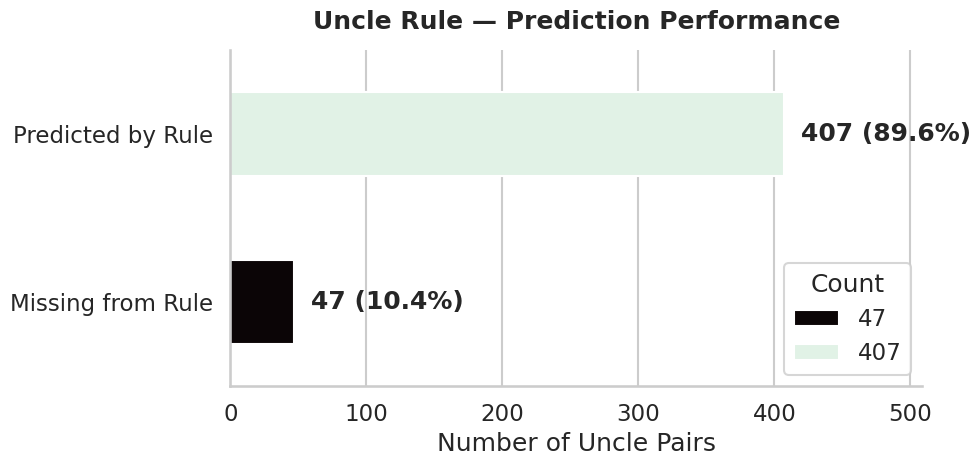

This rule only checks uncle relationships through BROTHERS
and direct parent links (father or mother).
1. Some uncles are married into the family (husband of aunt)
2. The brotherOf relationship may not be explicitly recorded for all sibling pairs
3. The dataset may have uncle relationships that bypass the brother->parent path


In [66]:
df = pd.DataFrame({
    "Category": [
        "Predicted by Rule",
        "Missing from Rule"
    ],
    "Count": [
        len(uncle_valid),
        reverse_missing
    ]
})

total = df["Count"].sum()
df["Percent"] = df["Count"] / total * 100

plt.figure(figsize=(10,5))

ax = sns.barplot(
    data=df,
    y="Category",
    x="Count",
    hue="Count",
    palette="mako",
    width=0.5
)

xmax = df["Count"].max()

for i, row in df.iterrows():
    ax.text(
        row["Count"] + xmax*0.03,
        i,
        f'{row["Count"]} ({row["Percent"]:.1f}%)',
        va="center",
        fontweight="bold"
    )

plt.title("Uncle Rule — Prediction Performance", pad=15, weight="bold")
plt.xlabel("Number of Uncle Pairs")
plt.ylabel("")

plt.xlim(0, xmax * 1.25)

sns.despine()
plt.tight_layout()
plt.show()


print("This rule only checks uncle relationships through BROTHERS")
print("and direct parent links (father or mother).")

print("1. Some uncles are married into the family (husband of aunt)")
print("2. The brotherOf relationship may not be explicitly recorded for all sibling pairs")
print("3. The dataset may have uncle relationships that bypass the brother->parent path")


# Rule 5: Cousin Inference 


**Rule**: `(sisterOf(X,Y) v brotherOf(X,Y)) ^ (fatherOf(X,Z) v motherOf(X,Z)) ^ (fatherOf(Y,W) v motherOf(Y,W)) ^ (Z != W) -> (boyCousinOf(Z,W) v girlCousinOf(Z,W))`

In plain English: If X and Y are siblings (brother or sister), and X is a parent of Z, and Y is a parent of W (where Z and W are different people), then Z and W are cousins.




In [67]:
boy_cousin_pairs = {(h, t) for h, r, t in triples if r == "boyCousinOf"}
girl_cousin_pairs = {(h, t) for h, r, t in triples if r == "girlCousinOf"}
actual_cousin_pairs = boy_cousin_pairs | girl_cousin_pairs

parent_to_children = {}
for parent, kids in father_pairs.items():
    parent_to_children.setdefault(parent, set()).update(kids)
for parent, kids in mother_pairs.items():
    parent_to_children.setdefault(parent, set()).update(kids)

sibling_pairs_set = set()
for h, r, t in triples:
    if r in ("sisterOf", "brotherOf"):
        sibling_pairs_set.add((h, t))

cousin_rule_instances = []
cousin_valid = []

for X, Y in sibling_pairs_set:
    children_of_X = parent_to_children.get(X, set())
    children_of_Y = parent_to_children.get(Y, set())
    
    for Z in children_of_X:
        for W in children_of_Y:
            if Z != W: 
                cousin_rule_instances.append((X, Y, Z, W))
                if (Z, W) in actual_cousin_pairs or (W, Z) in actual_cousin_pairs:
                    cousin_valid.append((X, Y, Z, W))

print(f"Cousin rule instances generated: {len(cousin_rule_instances)}")
print(f"Valid instances: {len(cousin_valid)}")


Cousin rule instances generated: 664
Valid instances: 664


In [68]:
reverse_check = 0
reverse_valid = 0

for Z, W in actual_cousin_pairs:
    found = False
    for inst in cousin_valid:
        if (inst[2] == Z and inst[3] == W) or (inst[2] == W and inst[3] == Z):
            found = True
            break

    reverse_check += 1
    if found:
        reverse_valid += 1

reverse_missing = reverse_check - reverse_valid

# Confidence = How many predictions are correct (precision)
confidence = len(cousin_valid) / len(cousin_rule_instances) if cousin_rule_instances else 0
# Coverage = How many actual relationships we found (recall)
coverage = reverse_valid / reverse_check if reverse_check else 0

print("RULE 5: (sisterOf(X,Y) v brotherOf(X,Y)) ^ (fatherOf(X,Z) v motherOf(X,Z)) ^ (fatherOf(Y,W) v motherOf(Y,W)) ^ (Z != W) -> (boyCousinOf(Z,W) v girlCousinOf(Z,W))")

print(f"\nTotal cousin pairs in dataset: {reverse_check}")
print(f"Predicted by rule (coverage): {reverse_valid}")
print(f"Not predicted by rule: {reverse_missing}")
print(f"\nRule predictions made: {len(cousin_rule_instances)}")
print(f"Correct predictions: {len(cousin_valid)}")

print(f"\nConfidence (Precision): {confidence:.4f} ({confidence*100:.2f}%)")

print(f"Coverage (Recall): {coverage:.4f} ({coverage*100:.2f}%)")

print(f"Support: {len(cousin_valid)}")


RULE 5: (sisterOf(X,Y) v brotherOf(X,Y)) ^ (fatherOf(X,Z) v motherOf(X,Z)) ^ (fatherOf(Y,W) v motherOf(Y,W)) ^ (Z != W) -> (boyCousinOf(Z,W) v girlCousinOf(Z,W))

Total cousin pairs in dataset: 836
Predicted by rule (coverage): 664
Not predicted by rule: 172

Rule predictions made: 664
Correct predictions: 664

Confidence (Precision): 1.0000 (100.00%)
Coverage (Recall): 0.7943 (79.43%)
Support: 664


In [ ]:
print("\nConcrete Examples:")
for i, (X, Y, Z, W) in enumerate(cousin_valid[:-1], 1):
    print(f"  {i}. {X} and {Y} are siblings")
    print(f"     {X} (parent)-> {Z}, {Y} (parent) {W}")
    print(f"     Rule predicts: cousinOf({Z}, {W})\n")


Concrete Examples:
  1. charlotte980 and jakob984 are siblings
     charlotte980 (parent)→ emilia983, jakob984 (parent)→ stefan991
     Rule predicts: cousinOf(emilia983, stefan991)

  2. charlotte980 and jakob984 are siblings
     charlotte980 (parent)→ tobias982, jakob984 (parent)→ stefan991
     Rule predicts: cousinOf(tobias982, stefan991)

  3. stefan677 and marko660 are siblings
     stefan677 (parent)→ anna681, marko660 (parent)→ karin657
     Rule predicts: cousinOf(anna681, karin657)

  4. lara1190 and anna1195 are siblings
     lara1190 (parent)→ stefan1192, anna1195 (parent)→ simon1197
     Rule predicts: cousinOf(stefan1192, simon1197)

  5. lara1190 and anna1195 are siblings
     lara1190 (parent)→ stefan1192, anna1195 (parent)→ vanessa1200
     Rule predicts: cousinOf(stefan1192, vanessa1200)

  6. marie215 and marcel214 are siblings
     marie215 (parent)→ jonathan219, marcel214 (parent)→ vanessa228
     Rule predicts: cousinOf(jonathan219, vanessa228)

  7. gabriel1248

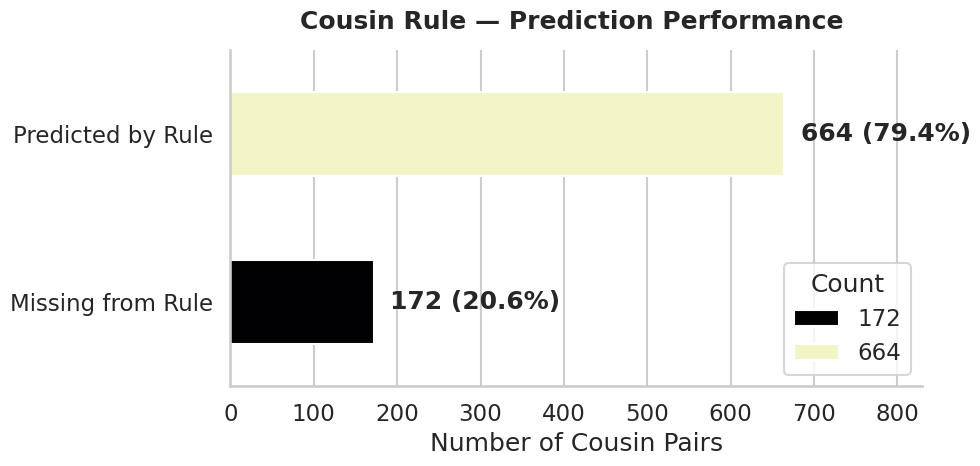

The cousin rule requires explicit sibling relationships (sisterOf/brotherOf) between parents.
The missing ~20% of cousin pairs occur because:
1. Not all sibling relationships are explicitly recorded in the dataset
2. Two people may share parents but lack explicit sisterOf/brotherOf triples
3. The dataset may have incomplete sibling information even when cousin relationships exist


In [70]:
df = pd.DataFrame({
    "Category": [
        "Predicted by Rule",
        "Missing from Rule"
    ],
    "Count": [
        len(cousin_valid),
        reverse_missing
    ]
})

total = df["Count"].sum()
df["Percent"] = df["Count"] / total * 100

plt.figure(figsize=(10,5))

ax = sns.barplot(
    data=df,
    y="Category",
    x="Count",
    hue="Count",
    palette="magma",
    width=0.5
)

xmax = df["Count"].max()

for i, row in df.iterrows():
    ax.text(
        row["Count"] + xmax*0.03,
        i,
        f'{row["Count"]} ({row["Percent"]:.1f}%)',
        va="center",
        fontweight="bold"
    )

plt.title("Cousin Rule — Prediction Performance ", pad=15, weight="bold")
plt.xlabel("Number of Cousin Pairs")
plt.ylabel("")

plt.xlim(0, xmax * 1.25)

sns.despine()
plt.tight_layout()
plt.show()

print("The cousin rule requires explicit sibling relationships (sisterOf/brotherOf) between parents.")
print("The missing ~20% of cousin pairs occur because:")
print("1. Not all sibling relationships are explicitly recorded in the dataset")
print("2. Two people may share parents but lack explicit sisterOf/brotherOf triples")
print("3. The dataset may have incomplete sibling information even when cousin relationships exist")



